# About this notebook

In this notebook, I explored the problem of the K-means algorithm for community detection from graph embedding. Then, I propose a remedy based on a simple statistical model that respects the fact that the embedding is generated by matrix factorization. I'll show that the clustering optimizes a Hamiltonian in the same form as the modularity, which enables us to determine the number of communities without the ground-truth. I demonstrate that the proposed method works better than the K-means algorithm, and can recover communities almost perfectly without the number of communities given in priori.  

# An issue of the K-means algorithm 

It is well known that the K-means algorithm performs poorly for imbalanced clusters. This problem is critical because many communities are skewed in size. We found this problem in large networks generated by the  LFR model. Let us demonstrate the problem. 


Load the data and embedding by node2vec. We use a network with a clear community structure, with mixing rate $\mu=0.2$. 


In [1]:
import numpy as np 
from scipy import sparse 
import pandas as pd

net_file = "../../data/lfr/networks/net_n~100000_k~50_tau~3_tau2~1_minc~50_mu~0.20_sample~6.npz"
node_file = "../../data/lfr/networks/node_n~100000_k~50_tau~3_tau2~1_minc~50_mu~0.20_sample~6.npz"
emb_file = "../../data/lfr/embedding/n~100000_k~50_tau~3_tau2~1_minc~50_mu~0.20_sample~6_model_name~node2vec_window_length~10_dim~64.npz"

net = sparse.load_npz(net_file)
node_table = pd.read_csv(node_file)
emb = np.load(emb_file)["emb"]

Define a function that calculates the element-centric similarity 

In [2]:
def calc_esim(y, ypred):
    """Element centric similarity."""
    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)

    Ka, Kb = len(ylab), len(ypredlab)

    K = np.maximum(Ka, Kb)
    N = len(y)
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N, K))
    UB = sparse.csr_matrix(
        (np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K)
    )

    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N

    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :])
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N

    # Calc the expected element-centric similarity for random partitions
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :])
    Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected    
    

Do clustering by K-means and OPTICS (i.e, a better version of DBSCAN)

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS

# Normalize the vector of each node to have unit length. This normalization improves clustering. 
X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb.copy()

# Clustering 
kmeans = KMeans(n_clusters=len(set(node_table["membership"])), random_state=0).fit(X)

# Evaluate the clustering
score_kmeans = calc_esim(node_table["membership"], kmeans.labels_)

print(f"Element-centric similarity:")
print(f"K-means: {score_kmeans}")

Element-centric similarity:
K-means: 0.8268771134418029


Cluster size distributions 

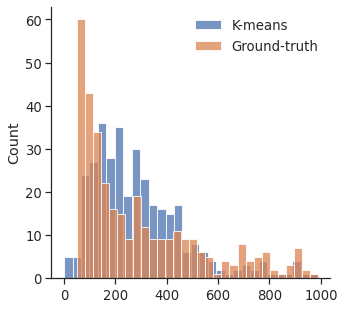

In [4]:
import matplotlib.pyplot as plt  
import seaborn as sns 


clus_sz = np.unique(node_table["membership"], return_counts=True)[1]
clus_sz_kmeans = np.unique(kmeans.labels_, return_counts=True)[1]

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(clus_sz_kmeans, bins = 30, label = "K-means", ax = ax)
sns.histplot(clus_sz, bins = 30, color = sns.color_palette().as_hex()[1], label = "Ground-truth", ax = ax)
ax.legend(frameon = False)
sns.despine()


The cluster size distribution for the planted communities is right-skewed and fat-tailed, i.e., many communities are small (less than 100) but large communities (of size greater than 900) also exist. The $K$-means algorithm detected size-homogeneous communities.  

### Testing off-the-shelf algorithms for imbalanced clustering 
What if we use another clustering algorithm that can find imbalanced clusters? The results are worse than the K-means algorithm. 
Let us use two density-based methods, DBSCAN and OPTICS. OPTICS is a variant of DBSCAN that fixes some issues of the DBSCAN. 

(Unfortunately, it didn't finish in 30 mins so I terminated. For smaller graph, the score is less than 0.1)

from sklearn.cluster import OPTICS, DBSCAN

# Normalize the vector of each node to have unit length. This normalization improves clustering. 
X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb.copy()

# Clustering 
dbscan = DBSCAN().fit(X)
optics = OPTICS().fit(X)

# Evaluate the clustering
score_dbscan = calc_esim(node_table["membership"], dbscan.labels_)
score_optics = calc_esim(node_table["membership"], optics.labels_)

print(f"Element-centric similarity:")
print(f"DBSCAN: {score_dbscan}")
print(f"OPTICS: {score_optics}")

# Proposed clustering method 

Many graph embedding explicitly or implicitly generates embedding based on matrix factorization. Additionally, the matrix takes a similar form of the modularity matrix. This observation can be utilized to improve the clustering. 

Suppose a graph embedding that generates an embedding ${\mathbf U}$ that factorizes a matrix ${\mathbf R}$ by  
\begin{align}
{\mathbf R} \simeq {\mathbf U} {\mathbf U}^\top
\end{align}
where $\mathbf U$ is the $N\times K$ matrix, $N$ is the number of nodes. and $K$ is the number of embedding dimensions. Previous approach assumes that if two nodes belong to the same communities, they have a similar embedding. This motivates the use of off-the-shelf clustering algorithms like K-means. Here, I propose another clustering method by focusing on the fact that the embedding is generated by factorization of ${\mathbf R}$. 

Let us consider a simple problem, where we are given two nodes and asked to predict whether they belong to the same community or not based on a similarity of the two nodes. More specifically, let $u_i$ and $u_j$ be the embedding vectors for nodes $i$ and $j$, and $g_i$ and $g_j$ be the communities to which $i$ and $j$ belong to, respectively. We use a logistic function to calculate the probability that $i$ and $j$ belong to the same community, i.e., 
\begin{align}
P(g_i = g_j) = \frac{1}{1 + \exp(-w_1 u_i^\top u_j + b_0 )}
\end{align}
where $w_1$ is the regression coefficient, and $b_0$ is the intercept. This step enables us to calculate the log-likelihood for community assignment $g_1,\ldots, g_N$, i.e., 
\begin{align}
{\cal L}(g_1, \ldots, g_N, w_1, b_0) = \sum_{i,j} \left[ \delta(g_i, g_j) \log P(g_i = g_j) +  (1-\delta(g_i, g_j)) \log (1-P(g_i = g_j)) \right].
\end{align}
If we know the model parameters $w_1$ and $b_1$, we can find the community assignment by maximizing ${\cal L}(g_1, \ldots, g_N, w_1, b_0)$. This can be done efficiently by noting that ${\cal L}(g_1, \ldots, g_N, w_1, b_0)$ can be rewritten in a form similar to the modularity:
\begin{align}
{\cal L}(g_1, \ldots, g_N, w_1, b_0) 
&= \sum_{i,j} \left[ \delta(g_i, g_j) \log \frac{P(g_i = g_j)}{1-P(g_i = g_j)} + \log (1-P(g_i = g_j))\right] \\
&=\sum_{i,j} \delta(g_i, g_j) \log \frac{P(g_i = g_j)}{1-P(g_i = g_j)} + \text{const.}  \\
&\propto \sum_{i,j} (w_1 u_i^\top u_j - b_0)\delta(g_i, g_j), 
\end{align}
which can be optimized efficiently using the Louvain algorithm, with a modification for vector data (I'll show you later).

#### How to estimate model parameters $w_1$ and $b_0$

The model parameters are not given in practice. If we have a ground-truth community assignment $\{ g_1, \ldots, g_N \}$, we can find the model parameters by maximizing ${\cal L}(g_1, \ldots, g_N, w_1, b_0)$ with respect to $w_1$ and $b_0$.

In practice, however, we don't know the ground-truth community assignment. What can we do? The idea is that we don't need the community assignment but $\delta(g_i,g_j)$. If the embedding captures communities, a node and its closest neighbor would belong to the same community. 

Building on this idea, I assume that $\delta(g_i,g_j) = 1$ if node $i$ is among the $k$-closest neighbor of $j$, or vise versa. Otherwise, $\delta(g_i,g_j) = 0$. I sample all pairs of the nearest neighbors $(i,j)$ and label them as $Y_{ij}=1$. Additionally,  I randomly sample node pairs $(i', j')$ uniformly at random and label them as $Y_{ij}=0$. Then, I find $w_1$ and $b_0$ by maximizing the log-likelihood:
\begin{align}
\hat {\cal L}(\{Y_{ij}\}_{i,j}, w_1, b_0) = \sum_{i,j} \left[ Y_{ij} \log P(g_i = g_j) +  (1-Y_{ij}) \log (1-P(g_i = g_j)) \right].
\end{align}

Once we find $w_1$ and $b_0$, we fix them and maximize ${\cal L}(g_1, \ldots, g_N, w_1, b_0)$ (not $\hat {\cal L}$!) with respect to the community assignment $g_1,\ldots, g_N$. As mentioned before, this can be done using a Louvain algorithm with a modification to vector data.


# Proof of concept

Let us find $w_0$ and $b_1$ by maximizing $\hat {\cal L}$. First, I sample k-nearest neighbors and random node pairs to train the logistic regression model:

In [5]:
import faiss

def find_knn_edges(
    emb,
    num_neighbors,
    target=None,
    metric="dotsim",
    device=None,
):

    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(
        emb if target is None else target,
        emb,
        num_neighbors=k,
        metric=metric,
        device=device,
    )

    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(
        int
    )
    r, c, distances = (
        r.reshape(-1),
        indices.astype(int).reshape(-1),
        distances.reshape(-1),
    )

    if len(r) == 0:
        return r, c, distances

    return r, c, distances


def find_knn(target, emb, num_neighbors, metric="dotsim", device=None):
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1])
    else:
        index = faiss.IndexFlatL2(emb.shape[1])
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
    else:
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1])
            else:
                index = faiss.IndexFlatL2(emb.shape[1])
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
    return indices, distances

rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=100, device = "cuda:0")
cneg = np.random.choice(emb.shape[0], len(cpos))
vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

Then, we train the logistic regression model to obtain $w_1$ and $b_0$:

In [6]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(
    np.concatenate([vpos, vneg]).reshape((-1, 1)),
    np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
)
w1, b0 = model.coef_[0, 0], -model.intercept_[0]
print(f"w0={w1}, b1={b0}")

w0=3.014276780325299, b1=20.203650562445564


Using the parameters, we find the communities using a Louvain algorithm for vector data:

In [7]:
import numba 

def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data

    :param Z: embedding 
    :type Z: numpy.ndarray 
    :param w1: regression coefficient 
    :type w1: float 
    :param b0: intercept 
    :type b0: float 
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """    

    # Initialize the intermediate variables 
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()

    # The main loop for the Louvain algorithm
    while True:

        # Find the community assignment for the given graph 
        # using a label switching algorithm
        cids_t = label_switching(
            Z=Vt,
            num_neighbors=num_neighbors,
            rho=b0/w1,
            node_size=node_size,
            epochs=iteration,
            device=device,
        )

        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)

        # If no merging, we are good to go out from the loop 
        if int(max(cids_t) + 1) == Vt.shape[0]:
            break

        # If two nodes are merged, we created an aggregated network, where 
        # a node represents a community.  
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        node_size = np.array(Ut.T @ node_size).reshape(-1)

    if return_member_matrix:
        return U

    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(
        -1
    )
    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None, epochs=50):

    num_nodes, dim = Z.shape

    if node_size is None:
        node_size = np.ones(num_nodes)

    Z = Z.copy(order="C").astype(np.float32)

    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device,
    )
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs,
    )


@numba.jit(nopython=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size, epochs=100):

    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1)
    for nid in range(num_nodes):
        Nc[nid] += node_size[nid]

    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False)
        updated_node_num = 0

        for _k, node_id in enumerate(order):

            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id])
            )
            for cprime in clist:
                if c == cprime:
                    continue
                dq = (
                    np.sum(Z[node_id, :] * Vc[cprime, :])
                    - rho * node_size[node_id] * Nc[cprime]
                ) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq

            if dqmax <= 1e-16:
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3:
            break
    return cids

gs = louvain(emb, w1, b0, device = "cuda:0")

Calculate the element-centric similarity of the detected clusters:

In [8]:
score_proposed = calc_esim(node_table["membership"], gs)
print(f"Element-centric similarity:")
print(f"Proposed: {score_proposed}")

Element-centric similarity:
Proposed: 0.9977667042868643


Although it's not perfect, it detected communities the best among all the methods tested above, without telling it the true number of communities. Also, the proposed method runs in speed comparable to the K-means. 

# Summary & Discussion 


### Why the proposed method works so well?

Let us focus on the modularity embedding, where ${\mathbf R} = {\mathbb A} - \langle {\mathbf A} \rangle$ is the modularity matrix. Because the embeddings are generated by matrix factorization, we can recover ${\mathbf R}$ from the embedding with a good accuracy, 
\begin{align}
{\mathbf R} ={\mathbb A} - {\mathbb E}[{\mathbf A}]\simeq {\mathbf U} {\mathbf U}^\top.
\end{align}
If the modularity can detect communities (which it does for stochastic block models), two nodes $i$ and $j$ in different communities have a negative similarity $R_{ij}<0$ while those in the same community have a positive similarity $R_{ij}>0$. In other words, we may obtain a good clustering by setting $\delta(g_i,g_j)$ according to the sign of $R_{ij}$, provided that the noise is small (which it does for large networks). The point is that we can get a good community assignment by thresholding the dot similarity. 

This argument can be applied to other graph embedding methods. In fact, the matrix for node2vec, DeepWalk, and LINE can be also rewritten in form of the modularity matrix, as shown in our manuscript. 

In practice, $R_{ij}$ has random fluctuations and can be systematically biased due to a small dimension and/or training algorithm (e.g., a gradient descent may be trapped in a local minima). Thus, we may be better by learning the decision boundary $b_0$ to decide $\delta(g_i,g_j)$ from a given embedding, instead of using a fixed $b_0$ (e.g., $b_0=0$ for the modularity maximization).

The choice of node similarity metrics is critical for clustering but this point has been largely overlooked (in my knowledge). The $K$-means algorithms as well as DBSCAN and OPTICS focus on the Euclidean distance between nodes. But if we consider how the graph embedding is generated, dot similarity is the one that encodes the similarity in the given network. The proposed method does clustering based on the dot similarity.

### Next step 
Evaluate the performance of the proposed method for the multipartition model and LFR benchmark. 

# Extended analysis 

## Using network edges to train the logistic regression
Filippo proposed a way to reduce the computation cost: instead of using the pairs of k-nearest neighbors to train the logistic regression model, we can use pairs of directly connected nodes. 

In [9]:
rpos, cpos, _ = sparse.find(net)
cneg = np.random.choice(emb.shape[0], len(cpos))

vpos = np.array(np.sum(emb[rpos, :] * emb[cpos, :], axis=1)).reshape(-1)
vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

model = LogisticRegression()
model.fit(
    np.concatenate([vpos, vneg]).reshape((-1, 1)),
    np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
)
w1, b0 = model.coef_[0, 0], -model.intercept_[0]
print(f"w0={w1}, b1={b0}")

w0=1.3285262062020569, b1=6.116828334229869


In [10]:
gs_net_edges = louvain(emb, w1, b0, device = "cuda:0")

score_proposed_net_edges = calc_esim(node_table["membership"], gs_net_edges)
print(f"Element-centric similarity:")
print(f"Proposed with network edges: {score_proposed_net_edges}")

Element-centric similarity:
Proposed with network edges: 0.8845078423634865


# LFR benchmark with different $\mu$

In [11]:
from tqdm.auto import tqdm 

rpos, cpos, _ = sparse.find(net)
cneg = np.random.choice(emb.shape[0], len(cpos))

vpos = np.array(np.sum(emb[rpos, :] * emb[cpos, :], axis=1)).reshape(-1)
vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

net_file_template = "../../data/lfr/networks/net_n~100000_k~50_tau~3_tau2~1_minc~50_mu~%.2f_sample~6.npz"
emb_file_template = f"../../data/lfr/embedding/n~100000_k~50_tau~3_tau2~1_minc~50_mu~%.2f_sample~6_model_name~node2vec_window_length~10_dim~64.npz"
node_file_template = f"../../data/lfr/networks/node_n~100000_k~50_tau~3_tau2~1_minc~50_mu~%.2f_sample~6.npz"

net = sparse.load_npz(net_file)
node_table = pd.read_csv(node_file)
mu_list = np.linspace(0.2, 0.9, 8) 
scores = []
for mu in tqdm(mu_list):
    emb = np.load(emb_file_template % mu)["emb"]
    net = sparse.load_npz(net_file_template % mu)
    node_table = pd.read_csv(node_file_template % mu)

    # Proposed
    rpos, cpos, _ = sparse.find(net)
    cneg = np.random.choice(emb.shape[0], len(cpos))

    model = LogisticRegression()
    vpos = np.array(np.sum(emb[rpos, :] * emb[cpos, :], axis=1)).reshape(-1)
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
    )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0]

    gs_lfr = louvain(emb, w1, b0, device = "cuda:0")

    scores.append({"mu":mu, "model":"Proposed","score":calc_esim(node_table["membership"], gs_lfr)})
    
    
    # K-means 
    # Normalize the vector of each node to have unit length. This normalization improves clustering. 
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))

    # Clustering 
    kmeans = KMeans(n_clusters=len(set(node_table["membership"])), random_state=0).fit(X)
    scores.append({"mu":mu, "model":"K-means","score":calc_esim(node_table["membership"], kmeans.labels_)})

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

(0.0, 1.0)

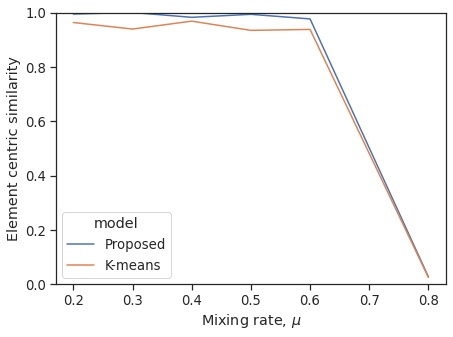

In [ ]:
plot_data = pd.DataFrame(scores)

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(data = plot_data, x = "mu", y = "score", hue = "model", ax = ax)
ax.set_xlabel("Mixing rate, $\mu$")
ax.set_ylabel("Element centric similarity")
ax.set_ylim(0,1)
#fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)